 We simulated 104
independent design matrices (n = 500,
p = 200) and binary responses from a logistic regression for the following two settings:
(1) (X1, . . . , Xp) is an AR(1) time series with AR coefficient 0.5 and
Y | X1, . . . , Xp ∼ Bernoulli(0.5)
(2) (X1, . . . , Xp) is an AR(1) time series with AR coefficient 0.5 and
Y | X1, . . . , Xp ∼ Bernoulli (logit (0.08(X2 + · · · + X21)))


In [29]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.special import expit #logit function

num_predictors = 200 
num_rows = 500 
ar_coef = 0.5
num_simulation = 10000

def generate_ar_data(num_rows = 500, num_predictors=200, ar_coef= 0.5,setting = 1):

    noise = np.random.normal(size=(num_rows, num_predictors))
    X = np.zeros((num_rows, num_predictors))
    
    for i in range(num_predictors):
        for time_point in range(1, num_rows): # we start from 1 since we want to use the previous value to predict the next value
            # a_x = phi * a_{x-1} + epsilon_x since AR(1) is used in the paper 
            X[time_point, i] = ar_coef * X[time_point-1, i] + noise[time_point, i]
    if setting == 1:
        Y = np.random.binomial(1, 0.5, size=num_rows)
    elif setting == 2:
        linear_predictor = 0.08 * np.sum(X[:, 1:21], axis=1) # Bernoulli(logit (0.08(X2 + · · · + X21)))
        probabilities = expit(linear_predictor) ## found using LLM 
        Y = np.random.binomial(1, probabilities,size=num_rows)
    return X,Y


def logistic_regression(X, Y):
    X = sm.add_constant(X) # intercept beta_0

    logit_model = sm.Logit(Y, X)
    logit_result = logit_model.fit()
    
    # p-value of beta_1 (as applied in the paper)
    p_1 = logit_result.pvalues[1]
    
    return p_1

In [36]:
def plot_hist(p_values):
    plt.hist(p_values, bins=20)
    plt.show()

def simulate(setting = 1):

    p_values = []
    X_list = []
    Y_list = []
    for i in range(int(10000)): 
        print(f'Iteration : {i}')
        if setting == 1:
            X,Y = generate_ar_data(setting=1)
        elif setting == 2:
            X,Y = generate_ar_data(setting=2)
        
        X_list.append(X)
        Y_list.append(Y)
        
        p_value = logistic_regression(X,Y)
        p_values.append(p_value)

    plot_hist(p_values)
    
    return p_values, X_list, Y_list
    

Iteration : 0
Optimization terminated successfully.
         Current function value: 0.494074
         Iterations 7
Iteration : 1
Optimization terminated successfully.
         Current function value: 0.383474
         Iterations 8
Iteration : 2
Optimization terminated successfully.
         Current function value: 0.423420
         Iterations 8
Iteration : 3
Optimization terminated successfully.
         Current function value: 0.408022
         Iterations 8
Iteration : 4
Optimization terminated successfully.
         Current function value: 0.410693
         Iterations 8
Iteration : 5
Optimization terminated successfully.
         Current function value: 0.439648
         Iterations 7
Iteration : 6
Optimization terminated successfully.
         Current function value: 0.402983
         Iterations 8
Iteration : 7
Optimization terminated successfully.
         Current function value: 0.408859
         Iterations 7
Iteration : 8
Optimization terminated successfully.
         Current fun

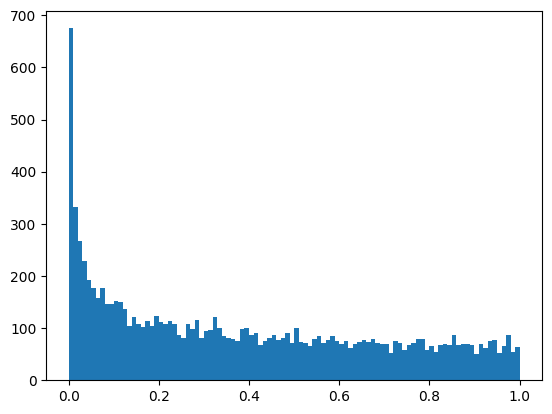

[0.40545375777971393,
 0.19080332559370994,
 0.6791408319910446,
 0.82099539534505,
 0.12948045792564014,
 0.6780327558931165,
 0.34357959967513974,
 0.5929629581155669,
 0.5959881949273933,
 0.38687553681493625,
 0.5810898605765469,
 0.7859064046609245,
 0.004170921684322637,
 0.0408406307433231,
 0.4468942956216776,
 0.7309493668915337,
 0.07050150722867496,
 0.17865238545611606,
 0.10817021645728232,
 0.7219471846524493,
 0.10409558427057547,
 0.15763362472189568,
 0.0932770345574067,
 0.13802423760282115,
 0.35190819145316743,
 0.11134204359962756,
 0.30435176155351173,
 0.6866495904543978,
 0.5620289492026924,
 0.9198162316052008,
 0.7270053807823031,
 0.10067185050720141,
 0.25093671704589937,
 0.10756302527272188,
 0.5143370985007109,
 0.1622947740469285,
 0.5892691271396285,
 0.1359210056293684,
 0.7075463080319031,
 0.012618163566522147,
 0.12511212233901375,
 0.012938646503584323,
 0.5135759931498176,
 0.5115565036946488,
 0.552366084680052,
 0.0036692850511948075,
 0.0929874

In [34]:
p_value_1, X_list_1, Y_list_1= simulate(setting=1)

In [ ]:
p_value_2, X_list_2, Y_list_2= simulate(setting=2)

In [54]:
import numpy as np
from sklearn.linear_model import LogisticRegression

def generate_conditional_samples(X, j):
    """
    Generate conditional samples for the jth column of X.
    """
    conditional_samples = np.copy(X)
    for i in range(X.shape[0]):
        # Remove the jth feature from the conditional sampling
        conditional_samples[i, j] = np.nan
        # Calculate conditional distribution based on other features
        conditional_distribution = X[~np.isnan(conditional_samples[:, j]), :][:, np.arange(X.shape[1]) != j]
        conditional_samples[i, j] = np.random.choice(conditional_distribution[:, j], size=1)
    return conditional_samples

def conditional_randomization_test(X, y, j, K=1000):
    """
    Perform Conditional Randomization Test.
    """
    original_Tj = Tj(X, y, j)
    count = 0
    for k in range(K):
        X_conditional = generate_conditional_samples(X, j)
        Tj_k = Tj(X_conditional, y, j)
        if Tj_k >= original_Tj:
            count += 1
    p_value = (count + 1) / (K + 1)
    return p_value

# Example of a feature importance statistic Tj
def Tj(X, y, j):
    """
    Compute the importance of feature Xj in predicting y using logistic regression.
    """
    logistic_reg = LogisticRegression()
    logistic_reg.fit(X, y)
    return np.abs(logistic_reg.coef_[0, j])



def simulate_conditional_randomization_test(X, Y,j=1):
    """
    Simulate the Conditional Randomization Test for the jth feature.
    """

    p_values = []
    for _ in range(10):
        X,Y = generate_ar_data(setting=1)
        p_values.append(conditional_randomization_test(X, Y, j,10))
    return p_values 

array_500_200 = np.random.rand(500, 200)
binary_array_500 = np.random.randint(0, 2, size=(500,))
p_value_crf = simulate_conditional_randomization_test(array_500_200,binary_array_500,1)



In [55]:
p_value_crf

[0.9090909090909091,
 0.5454545454545454,
 1.0,
 0.9090909090909091,
 0.36363636363636365,
 0.8181818181818182,
 0.9090909090909091,
 0.45454545454545453,
 0.6363636363636364,
 0.09090909090909091]